<table style="border:none; border-collapse:collapse; cellspacing:0; cellpadding:0">
    <tr>
        <td width=30% style="border:none">
            <img src="logo_datascientest.png" width="100%"/>
        </td>
        <td style="border:none">
            <center>
                <h1>DS project: Customer satisfaction</h1>
                <h2>Topic Modeling - BERTopic</h2>
            </center>
        </td>
    </tr>
</table>

<hr>

**Date** : 2023

**Author** : Elie MAZE, Luc Thomas

**Goal** : Trouver les topics à partir d'avis de clients et estimer comment ils sont liés à des sujets de mécontentements ou  de satisfaction:  
- experience utilisateur  
- livraison / logistique  
- service client  
- qualité du produit  
   ...

In [65]:
import _mypath
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from threadpoolctl import threadpool_limits

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, Phraser

from random import choice

import nltk
nltk.data.path.append("/data/DATALAB_PAU/18_HPC/nltk_data")
from nltk.corpus import stopwords

from pprint import pprint

from data.processing import plot_word_cloud
from visu.visu import plotVectors

from IPython.display import IFrame

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
print("pyLDAvis: {0}".format(pyLDAvis.__version__))

pyLDAvis.enable_notebook()

pyLDAvis: 3.4.0


In [3]:
stop_words = stopwords.words('french')

In [67]:
PRJ_FOLDER = "/data/DATALAB_PAU/20_projects/j0215602/DS_NLP"
#PRJ_FOLDER = r"D:\DevPy\DS_NLP"

DATA_FOLDER = os.path.join(PRJ_FOLDER, "input", "processed")
OUTDIR = os.path.join(PRJ_FOLDER, "lda_results")

_MAX_WORKERS = 8

# Data loading

In [5]:
infile = os.path.join(DATA_FOLDER, "processed_dataset.csv")
df = pd.read_csv(infile, sep=",", encoding="utf-8", engine="python")

print("data set:", df.shape)

data set: (105511, 11)


In [6]:
df.head(5)

,Commentaire,star,date,client,reponse,source,company,langage,cleaned_words,cleaned_lemma,Sentiment
0,"Colis commandé mardi 28 fevrier 23 , livraiso...",1,2023-03-07,Toto,NaN,TrustPilot,Amazon,fr,colis commandé mardi fevrier livraison jeu...,colis commander mardi fevrier livraison je...,__label__NEGATIVE
1,Amazon avec sa politique de retour est la pire...,1,2023-03-07,nasri eddine,NaN,TrustPilot,Amazon,fr,amazon politique pire contrairement ...,amazon politique pire contrairement ...,__label__NEGATIVE
2,Dieu sait que j'en connais des déboires avec l...,4,2023-03-07,Amandine,NaN,TrustPilot,Amazon,fr,dieu connais déboires sites marchands ...,dieu connaître déboire site marchand a...,__label__POSITIVE
3,"Nul, preleve une commande que je n'ai jamais r...",1,2023-03-07,Bob Brico,NaN,TrustPilot,Amazon,fr,preleve commande jamais reçu service cl...,prelev commande jamais recevoir service...,__label__NEGATIVE
4,Colis soit disant livré mais jamais reçu donc ...,1,2023-03-06,Client,NaN,TrustPilot,Amazon,fr,colis disant livré jamais reçu perdu non re...,colis dire livrer jamais recevoir perdre no...,__label__NEGATIVE


In [7]:
df.star.value_counts()

star
5    52991
1    24140
4    18418
3     6355
2     3607
Name: count, dtype: int64

In [8]:
SAMPLE_NB = 2000
print("samples per star:", SAMPLE_NB)

samples = []

for star in range(1,6):
    satisfaction = "negative"
    if star==3:
        satisfaction = "neutral"
    elif star>3:
        satisfaction = "positive"
        
    mask = (df["star"]==star)
    sample = df.loc[mask, ["Commentaire", "cleaned_words", "cleaned_lemma", "star"]].sample(n=SAMPLE_NB)
    sample["satisfaction"] = satisfaction
    samples += [sample]

samples = pd.concat(samples)
samples = samples.reset_index(drop=True)

print("Samples:", samples.shape)
samples.head(5)

samples per star: 2000
Samples: (10000, 5)


,Commentaire,cleaned_words,cleaned_lemma,star,satisfaction
0,"Bonjour, je tiens a prévenir tout le monde du ...",bonjour prévenir monde vol frauduleux ...,bonjour prévenir monde vol frauduleux ...,1,negative
1,Mon litige avec C Discount dure depuis décembr...,litige discount dure décembre suite avi...,litige discount dur décembre suite avis...,1,negative
2,Les codes de réductions ne fonctionnent pas po...,codes réductions fonctionnent etudiants,code réduction fonctionner etudiant,1,negative
3,Très déçue. Je commande un jeu de croquet pour...,déçue commande jeu croquet été env r...,déçu commande jeu croquet être env r...,1,negative
4,"Service client inexistant, j'ai commandé un té...",service client inexistant commandé télépho...,service client inexistant commander téléph...,1,negative


In [9]:
reviews = samples["Commentaire"].tolist()
cleaned_reviews = samples["cleaned_words"].tolist()
lemma_reviews = samples["cleaned_lemma"].tolist()

print("reviews:", len(reviews), end="\n\n")
print(reviews[10], end="\n\n")

print("lemmas:")
print(lemma_reviews[10])

reviews: 10000

Bonjour à tous, petit retour sur le "leader de l'E-commerce Français" CDISCOUNT.Tout se passe bien pour passer commande et payer, forcément. je précise qu'il s'agit d'un TV LG 65 pouces. Facturé 37 euros de livraison tout de même.Commande passée le 2 juin. toujours pas expédiée à ce jour.Appel à CDISCOUNT le 8 Juin au service client qui m'indique qu'il n'est pas responsable car il n'est pas l'expéditeur direct du produit.leur service m'indique donc contacter directement le vendeur et laisser couler 48 ouvrés.Forcément, rien ne se produit, toujours pas de livraison.A l'issue des 48 heures ouvrées, nouvel appel à CDISCOUNT, m'indiquant que le vendeur a été notifié, mais toujours sans réponse. Aucune preuve ne m'est fournie.Dans le même temps, je parviens par mes propres moyen à contacter le vendeur (Société sans numéro de téléphone répondant au nom de EJACOS).Encore une fois, CDISCOUNT est incapable de me rendre des comptes sur son partenaire commercial.Le vendeur de EJAC

# 1-grams
## Prepare data for LDA Analysis

In [10]:
def sent_to_words(comments):
    for sentence in comments:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [11]:
comments_words = list(sent_to_words(lemma_reviews))

print("comments_words:", len(comments_words))
comments_words[0]

comments_words: 10000


['bonjour',
 'prevenir',
 'monde',
 'vol',
 'frauduleux',
 'cdiscount',
 'intermediaire',
 'paypal',
 'service',
 'prepayer',
 'eventuel',
 'livraison',
 'etre',
 'facturer',
 'euro']

In [19]:
# create dictionary
id2word = corpora.Dictionary(comments_words)

# create Corpus
# Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in comments_words]

In [20]:
print("Corpus:", end="\n\n")
print(0, corpus[0])
print(1, corpus[1])
print("...")
print("N", corpus[-1])

Corpus:

0 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)]
1 [(19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]
...
N [(108, 1), (116, 1), (135, 1), (203, 1), (243, 1), (366, 1), (573, 1), (618, 1), (1226, 1), (2488, 1), (4968, 1)]


## LDA model training

La cohérence (C_v) calcule la similarité entre les paires de mots présents dans un même sujet pour mesurer la cohérence intra-sujet. Plus précisément, elle calcule la mesure de similarité entre les mots en utilisant la mesure de co-occurrence pointwise mutual information (PMI).

In [34]:
benchmark = []
topic_range = range(4,15)
for k in topic_range:
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=10, workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=comments_words, dictionary=id2word, coherence='c_v')
    benchmark += [ [k, coherence_model_lda.get_coherence()] ]
    
bench_data = pd.DataFrame(benchmark)
bench_data.columns = ["k", "coherence"]

In [41]:
bench_data

,k,coherence
0,4,0.507972
1,5,0.515276
2,6,0.477113
3,7,0.458641
4,8,0.514857
5,9,0.506380
6,10,0.501349
7,11,0.508384
8,12,0.498023
9,13,0.511727


In [42]:
i = bench_data["coherence"].argmax()
print("Optimal number of topics:",  bench_data.at[i, "k"])

Optimal number of topics: 5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


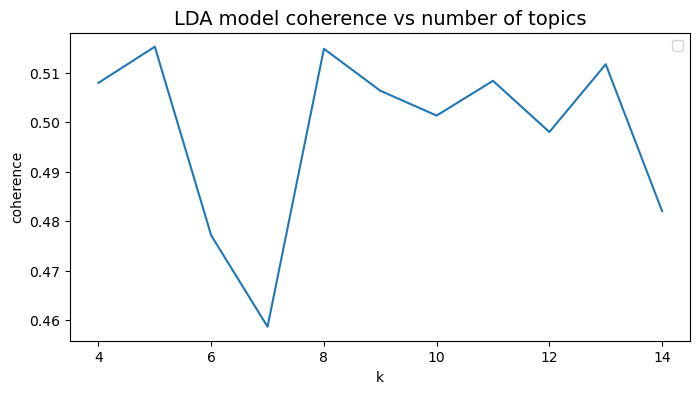

In [40]:
plt.figure(figsize=(8,4))
plt.title('LDA model coherence vs number of topics', fontsize=14)
sns.lineplot(data=bench_data, x='k', y='coherence')
plt.xlabel("k")
plt.legend()
plt.show()

In [43]:
# number of topics
num_topics = 5

# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10, workers=2)

# print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.018*"vendeur" + 0.017*"produit" + 0.016*"avis" + 0.014*"acheter" + '
  '0.013*"cdiscount" + 0.013*"fnac" + 0.013*"site" + 0.010*"amazon" + '
  '0.008*"faire" + 0.006*"bien"'),
 (1,
  '0.021*"service" + 0.020*"client" + 0.020*"commande" + 0.013*"amazon" + '
  '0.012*"etre" + 0.012*"jour" + 0.011*"colis" + 0.011*"recevoir" + '
  '0.009*"cdiscount" + 0.009*"faire"'),
 (2,
  '0.024*"cdiscount" + 0.021*"carte" + 0.021*"frais" + 0.018*"prix" + '
  '0.014*"article" + 0.014*"site" + 0.013*"payer" + 0.013*"fois" + '
  '0.012*"livraison" + 0.012*"trop"'),
 (3,
  '0.053*"commande" + 0.031*"livraison" + 0.026*"bien" + 0.025*"passer" + '
  '0.016*"livrer" + 0.015*"rien" + 0.014*"bon" + 0.014*"colis" + 0.013*"fois" '
  '+ 0.012*"cdiscount"'),
 (4,
  '0.040*"bon" + 0.040*"livraison" + 0.038*"site" + 0.032*"rapide" + '
  '0.031*"produit" + 0.031*"prix" + 0.025*"bien" + 0.021*"cdiscount" + '
  '0.019*"choix" + 0.019*"commande"')]


## Analyzing LDA model results

In [45]:
# visualize the topics
LDAvis_data_filepath = os.path.join(OUTDIR, 'ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

D:\Programmes\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [46]:
LDAvis_visu_filepath = os.path.join(OUTDIR, 'ldavis_prepared_'+str(num_topics) +'.html')

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, LDAvis_visu_filepath)

In [47]:
topics = lda_model.get_document_topics(corpus, per_word_topics=False)
len(topics)

18035

In [48]:
THRESHOLD = 0.2

max_topic = 0
stats = []
for i, doc_topics in enumerate(topics):
    for topic, proba in doc_topics:
        if proba<0.2: continue
        
        star = samples.at[i, "star"]
        stats += [[topic, proba, star]]
            
stats = pd.DataFrame(stats)
stats.columns = ["topic", "proba", "star"]

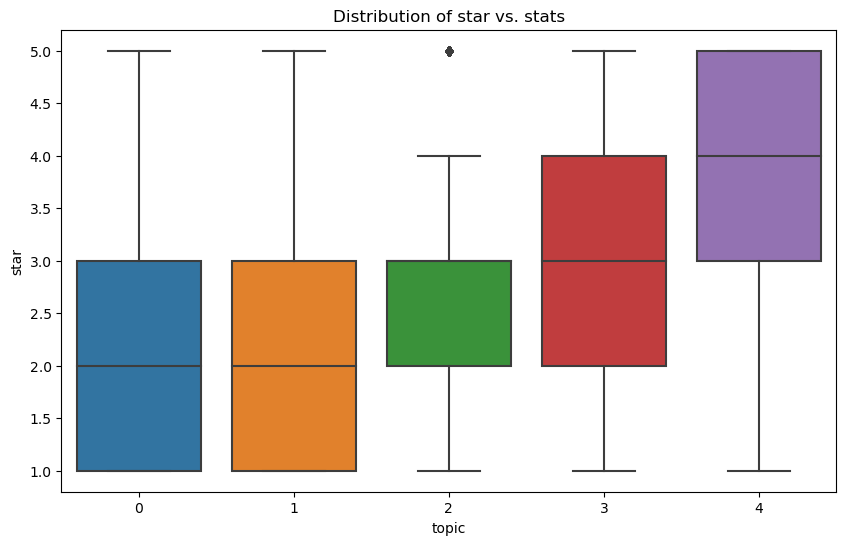

In [49]:
fig, ax = plt.subplots(figsize=[10,6])
sns.boxplot(x="topic", y="star", data=stats, ax=ax)
plt.title("Distribution of star vs. stats")
plt.show()

In [51]:
index = choice(range(0, len(reviews)))

print("index:", index, end="\n\n")
print(reviews[index], end="\n\n")

doc_topics = topics[index]
for topic, prob in doc_topics:
    if prob>THRESHOLD:
        print(f"Topic {topic}, Probability {prob}")
        for term, tprob in lda_model.show_topic(topic):
            print("  ", term, "  ", tprob)
        print()

index: 4113

J'ai été client  longtemps chez amazon , mais depuis cette nouvelle habitude avec leurs livreurs de laisser mes colis chez des inconnus sans me demander mon accord ni même avertir , j'ai décidé de refuser mes derniers colis et ce sera mes dernières commandes en ligne . En tout cas chez eux .

Topic 1, Probability 0.8975427746772766
   service    0.020598132
   client    0.020201609
   commande    0.01964285
   amazon    0.013490512
   etre    0.012460366
   jour    0.01218225
   colis    0.011359947
   recevoir    0.0106516015
   cdiscount    0.009087925
   faire    0.00876274



## Conclusion

Les thematiques principales associés aux 5 topics sont les suivantes:  
  
cluster 1  
- produits 
- passer commande  
- livraisons et logistique 
- service client  
    
cluster 2  
- produits  
- experience avec le vendeur  
- avis  
  
cluster 3  
- paiement et au prix/frais  
  
cluster 4  
- prix, 
- service client 
- qualité du produit et au choix  
- rapidité de la livraison  
  
  
cluster 5  
- passer commande  
- livraisons et la logistique  

# n-grams

In [98]:
from nltk import ngrams

comments_words = list(sent_to_words(lemma_reviews))
reviews_bigrams = [["_".join(list(items)) for items in ngrams(words, 2)] for words in comments_words] 
len(reviews_bigrams)

10000

In [104]:
from collections import Counter
counter = Counter([grams for review in reviews_bigrams for grams in review])
for k, v in counter.items():
    v /= len(reviews_bigrams)
    counter[k] = v

<AxesSubplot:>

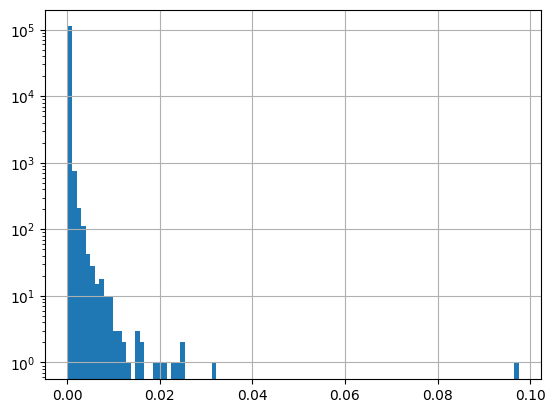

In [113]:
stats = pd.DataFrame.from_dict(counter, orient="index", columns=["count"])
stats["count"].hist(log=True, bins=100)

In [114]:
m = (stats["count"]>0)
stats.loc[m, "count"].min()

0.0001

In [118]:
cleaned_bigrams = [bigrams for bigrams in [[item for item in items if counter[item]>=0.001] for items in reviews_bigrams] if bigrams ]
len(cleaned_bigrams)


8038

In [123]:
cleaned_bigrams[0]

['livraison_etre', 'facturer_euro']

In [119]:
# create dictionary
id2word = corpora.Dictionary(cleaned_bigrams)

# create Corpus
# Term Document Frequency (TDF)
corpus = [id2word.doc2bow(text) for text in cleaned_bigrams]

## LDA model training

In [126]:
benchmark = []
topic_range = range(4,15)
for k in tqdm(topic_range):
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=k, passes=10, workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_bigrams, dictionary=id2word, coherence='c_v')
    benchmark += [ [k, coherence_model_lda.get_coherence()] ]
    
bench_data = pd.DataFrame(benchmark)
bench_data.columns = ["k", "coherence"]

100%|██████████| 11/11 [01:28<00:00,  8.04s/it]


In [127]:
bench_data

,k,coherence
0,4,0.374781
1,5,0.429234
2,6,0.487797
3,7,0.446573
4,8,0.425202
5,9,0.487790
6,10,0.437166
7,11,0.462850
8,12,0.494401
9,13,0.458391


In [128]:
i = bench_data["coherence"].argmax()
print("Optimal number of topics:",  bench_data.at[i, "k"])

Optimal number of topics: 14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


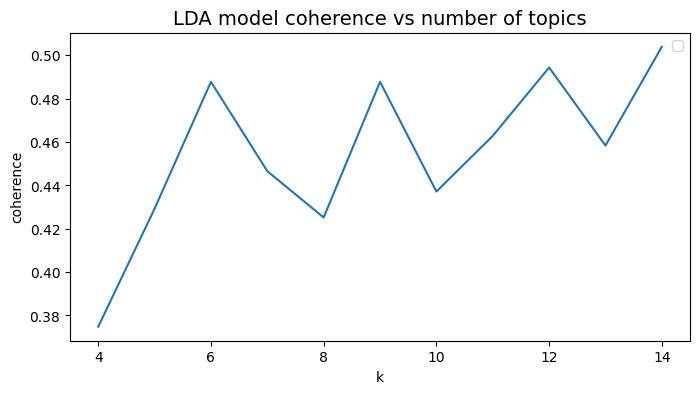

In [129]:
plt.figure(figsize=(8,4))
plt.title('LDA model coherence vs number of topics', fontsize=14)
sns.lineplot(data=bench_data, x='k', y='coherence')
plt.xlabel("k")
plt.legend()
plt.show()

In [130]:
# number of topics
num_topics = 6

# build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, passes=10, workers=2)

# print the Keyword in the 10 topics
pprint(lda_model.print_topics())

[(0,
  '0.019*"paiement_fois" + 0.014*"service_client" + 0.014*"commande_passer" + '
  '0.013*"etre_livrer" + 0.013*"bien_passer" + 0.013*"passer_commande" + '
  '0.012*"recevoir_colis" + 0.011*"aujourd_hui" + 0.011*"recevoir_commande" + '
  '0.009*"jamais_souci"'),
 (1,
  '0.048*"livraison_rapide" + 0.032*"bon_site" + 0.027*"qualite_prix" + '
  '0.020*"rapport_qualite" + 0.019*"delai_livraison" + 0.017*"beaucoup_choix" '
  '+ 0.016*"rien_redire" + 0.016*"bon_service" + 0.015*"choix_prix" + '
  '0.015*"bon_produit"'),
 (2,
  '0.038*"frais_port" + 0.035*"service_client" + 0.025*"carte_cdiscount" + '
  '0.024*"livraison_gratuit" + 0.023*"bon_achat" + 0.017*"frais_livraison" + '
  '0.015*"payer_fois" + 0.011*"cdiscount_volonte" + 0.010*"grand_choix" + '
  '0.009*"payer_frais"'),
 (3,
  '0.046*"service_client" + 0.017*"bon_achat" + 0.014*"bon_prix" + '
  '0.013*"delai_livraison" + 0.012*"dernier_commande" + 0.011*"choix_produit" '
  '+ 0.011*"prix_interessant" + 0.010*"fnac_com" + 0.009*"j

## Analyzing LDA model results

In [131]:
# visualize the topics
LDAvis_data_filepath = os.path.join(OUTDIR, 'ldavis_prepared_bigrams_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
    pickle.dump(LDAvis_prepared, f)

In [132]:
LDAvis_visu_filepath = os.path.join(OUTDIR, 'ldavis_prepared_bigrams_'+str(num_topics) +'.html')

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
    
pyLDAvis.save_html(LDAvis_prepared, LDAvis_visu_filepath)

In [133]:
topics = lda_model.get_document_topics(corpus, per_word_topics=False)
len(topics)

8038

In [134]:
THRESHOLD = 0.2

max_topic = 0
stats = []
for i, doc_topics in enumerate(topics):
    for topic, proba in doc_topics:
        if proba<0.2: continue
        
        star = samples.at[i, "star"]
        stats += [[topic, proba, star]]
            
stats = pd.DataFrame(stats)
stats.columns = ["topic", "proba", "star"]

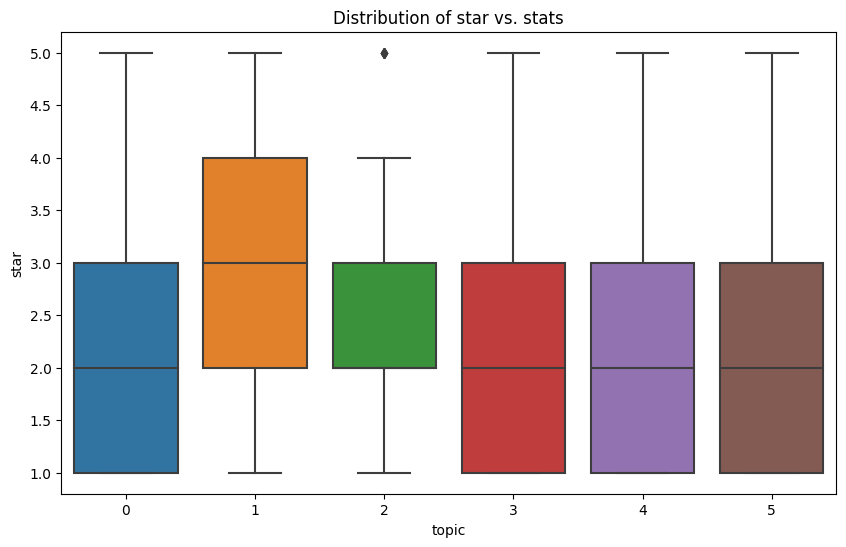

In [135]:
fig, ax = plt.subplots(figsize=[10,6])
sns.boxplot(x="topic", y="star", data=stats, ax=ax)
plt.title("Distribution of star vs. stats")
plt.show()

In [136]:
index = choice(range(0, len(reviews)))

print("index:", index, end="\n\n")
print(reviews[index], end="\n\n")

doc_topics = topics[index]
for topic, prob in doc_topics:
    if prob>THRESHOLD:
        print(f"Topic {topic}, Probability {prob}")
        for term, tprob in lda_model.show_topic(topic):
            print("  ", term, "  ", tprob)
        print()

index: 6586

Encore beaucoup trop de descriptions imprécises ou découlant d'une traduction très approximative qui nuisent à la bonne compréhension des caractéristiques des produits, et aussi des photos ne montrant pas exactement l'article concerné induisant des doutes sur le choix, comme par exemple une photo de clé de 17 quand l'annonce décrit une clé de 21...Autrement large choix, tarifs concurrentiels en général et les livraisons globalement rapides.

Topic 1, Probability 0.5833298563957214
   livraison_rapide    0.048303347
   bon_site    0.03157251
   qualite_prix    0.026611771
   rapport_qualite    0.02014309
   delai_livraison    0.019285506
   beaucoup_choix    0.016859787
   rien_redire    0.01636906
   bon_service    0.015868438
   choix_prix    0.015201332
   bon_produit    0.014689308



## Conclusion

Les thematiques principales associés aux 5 topics sont les suivantes:  
  
cluster 1: experience user, service et livraison    
- site... 
- service client  
- delai livraison  
- point relais  
- etre livré
  
cluster 2:
- paiement plusieurs fois
- bon produit  
- etre livré
- recevoir commande/colis  
  
cluster 3: prix-paiement  
- frais de port / livraison
- payer en plusieurs fois
- bon d'achat, carte CDiscount  
  
cluster 4  
- rapidité/délai de la livraison  
- bon d'achat  
- prix 
- service client
- choix produit  
  
cluster 5  
- fais de livraison  
- commande CDiscount  
- passer commande
  
cluster 6: offre et prix et service  
- prix/rapidité/délai de la livraison  
- service  
- produit  
- experience user (ergonomie, site...)  
- rapport qualité/prix  
- choix  

L'approche bi-grams apporte un peu plus de contexte, permet d'inclure des sujets plus clairs pour chaque topic.    
  
De façon générale, l'approche BoW est simple a mettre en oeuvre et beaucoup plus rapide que l'utilisation de modeles de deep learning.   
Il facile d'interpréter les résultats de topic modeling puisque chaque commentaire est représentré par un ensemble de n-grams.  
Mais cette approche ne tient pas compte de l'ordre des mots, de leur signification (synonymes, etc.) ni de la relation entre les mots.  
Beaucoup de topics ont un vocabulaire commun.  
  